<h6>This project aims to predict the winner of tennis matches in the ATP Men's Tour Tennis by utilizing various odds indicators. Odds serve as crucial indicators of probability, reflecting the likelihood of such events occurring.</h6>

In [90]:
# Scientific Computing 
import numpy as np

# Data manipulation and analysis
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV

# Regression Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score, explained_variance_score

# Feature Selection
from sklearn.feature_selection import SelectKBest

# Split data
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# Decomposition
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Statistics
from statsmodels.tsa.stattools import grangercausalitytests

# Database
import sqlite3

# Time-related functions
import time

pd.set_option("display.max_columns", None)

<p><h3>Data Collection</h3>
<h6>Obtain the tabular data (.db) from database.</h6>
</p>

In [91]:
# Connect to the SQLite database
connection = sqlite3.connect(f"../data/processed/apt-tour.db")

# Fetch data into a DataFrame
df_database = pd.read_sql_query("SELECT * FROM matches;", connection)

# Close the connection
connection.close()

# Display the DataFrame
df_database.tail()

,id,atp,tournament,date,season,series,court,surface,round,best_of,winner,loser,wrank,lrank,wpts,lpts,w1,l1,w2,l2,w3,l3,w4,l4,w5,l5,wsets,lsets,comment,b365w,b365l
1711,5120230831MmohMIsnerJ,51,US Open,2023-08-31,2023,Grand Slam,Outdoor,Hard,2nd Round,5,Mmoh M.,Isner J.,89,157,644,400,3,None,4,None,7,None,6,None,7,None,3,2,Completed,1.80,2.00
1712,5120230831ArnaldiMFilsA,51,US Open,2023-08-31,2023,Grand Slam,Outdoor,Hard,2nd Round,5,Arnaldi M.,Fils A.,61,48,855,1007,3,None,7,None,7,None,5,None,6,None,3,2,Completed,2.30,1.62
1713,5120230901StrickerDBonziB,51,US Open,2023-09-01,2023,Grand Slam,Outdoor,Hard,3rd Round,5,Stricker D.,Bonzi B.,128,108,480,555,2,None,7,None,7,None,3,None,6,None,3,2,Completed,1.67,2.20
1714,5120230902DjokovicNDjereL,51,US Open,2023-09-02,2023,Grand Slam,Outdoor,Hard,3rd Round,5,Djokovic N.,Djere L.,2,38,9795,1110,4,None,4,None,6,None,6,None,6,None,3,2,Completed,1.01,26.00
1715,5120230905ZverevASinnerJ,51,US Open,2023-09-05,2023,Grand Slam,Outdoor,Hard,4th Round,5,Zverev A.,Sinner J.,12,6,2670,4645,6,None,3,None,6,None,4,None,6,None,3,2,Completed,2.38,1.57


<p><h3>Data Cleaning</h3>
<h6>Preprocess the data to handle missing values, outliers, duplicates, and inconsistencies. This ensures that the data is accurate and ready for analysis.</h6></p>

In [92]:
df = df_database.copy()
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1716 non-null   string 
 1   atp         1716 non-null   string 
 2   tournament  1716 non-null   string 
 3   date        1716 non-null   string 
 4   season      1716 non-null   string 
 5   series      1716 non-null   string 
 6   court       1716 non-null   string 
 7   surface     1716 non-null   string 
 8   round       1716 non-null   string 
 9   best_of     1716 non-null   Int64  
 10  winner      1716 non-null   string 
 11  loser       1716 non-null   string 
 12  wrank       1716 non-null   Int64  
 13  lrank       1716 non-null   Int64  
 14  wpts        1716 non-null   Int64  
 15  lpts        1716 non-null   Int64  
 16  w1          1716 non-null   Int64  
 17  l1          0 non-null      object 
 18  w2          1716 non-null   Int64  
 19  l2          0 non-null     

<p><h4>Filter the dataframe</h4>
<h6>Filter the dataframe only with the season 2023 and 2024 and create new features</h6></p>

In [93]:
df = df[df["season"].isin(["2018", "2019", "2020", "2021", "2022", "2023", "2024"])]
df = df[["wrank", "lrank", "wpts", "lpts", "b365w", "b365l"]]
df.tail()

,wrank,lrank,wpts,lpts,b365w,b365l
1711,89,157,644,400,1.8,2.0
1712,61,48,855,1007,2.3,1.62
1713,128,108,480,555,1.67,2.2
1714,2,38,9795,1110,1.01,26.0
1715,12,6,2670,4645,2.38,1.57


<p><h3>Exploratory Data Analysis (EDA)</h3>
<h6>Perform initial exploration of the data to understand its structure, distribution, and relationships. This involves generating summary statistics, visualizations (e.g., histograms, scatter plots, box plots), and identifying patterns or trends.</h6></p>

In [94]:
print(df.info())

print(df["wpts"].max())
print(df["wpts"].min())
print(df["lpts"].max())
print(df["lpts"].min())

total_matches = len(df)
print(f"Total matches: {total_matches}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 1715
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wrank   596 non-null    Int64  
 1   lrank   596 non-null    Int64  
 2   wpts    596 non-null    Int64  
 3   lpts    596 non-null    Int64  
 4   b365w   596 non-null    Float64
 5   b365l   596 non-null    Float64
dtypes: Float64(2), Int64(4)
memory usage: 36.1 KB
None
12415
95
12355
3
Total matches: 596


<p><h3>Feature Engineering</h3>
<h6>Create new features or transform existing ones to enhance the predictive power of the data. This may involve techniques like scaling, encoding categorical variables, or extracting new features from existing ones.</h6></p>

In [95]:
df.loc[:, "b365w_probability"] = 1 / df["b365w"]
df.loc[:, "b365l_probability"] = 1 / df["b365l"]

# Verify if the rank of the winner is more high then loser, because a tennist with a good position on the rank is more "inclined" to win
df.loc[:, "corresponding_ranking"] = df.apply(lambda row: 1 if row["wrank"] < row["lrank"] else 0, axis=1)

# Verify if the probability of the winner is appropriate accordingly with the result
df.loc[:, "corresponding_probability"] = df.apply(lambda row: 1 if row["b365w"] < row["b365l"] else 0, axis=1)

df

,wrank,lrank,wpts,lpts,b365w,b365l,b365w_probability,b365l_probability,corresponding_ranking,corresponding_probability
0,65,94,835,629,1.62,2.3,0.617284,0.434783,1,1
1,21,257,1760,228,1.36,3.2,0.735294,0.3125,1,1
2,5,77,5010,718,1.03,17.0,0.970874,0.058824,1,1
3,68,86,814,680,1.44,2.75,0.694444,0.363636,1,1
4,12,90,2840,661,1.03,15.0,0.970874,0.066667,1,1
...,...,...,...,...,...,...,...,...,...,...
1711,89,157,644,400,1.8,2.0,0.555556,0.5,1,1
1712,61,48,855,1007,2.3,1.62,0.434783,0.617284,0,0
1713,128,108,480,555,1.67,2.2,0.598802,0.454545,0,1
1714,2,38,9795,1110,1.01,26.0,0.990099,0.038462,1,1


<p><h3>Statistical Analysis</h3>
<h6>Apply statistical methods to uncover relationships between variables, test hypotheses, and validate assumptions. Common statistical techniques include correlation analysis, hypothesis testing, and regression analysis.</h6></p>

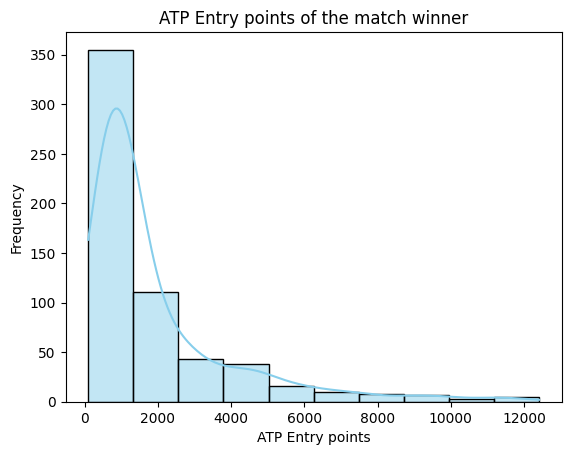

In [96]:
# Create a distribution plot
sns.histplot(df["wpts"], kde=True, color="skyblue", bins=10)
plt.xlabel("ATP Entry points")
plt.ylabel("Frequency")
plt.title("ATP Entry points of the match winner")
plt.show()

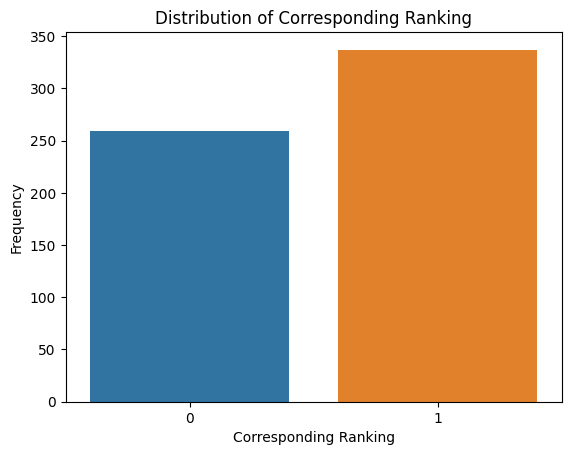

In [97]:
sns.countplot(x="corresponding_ranking", data=df)
plt.xlabel("Corresponding Ranking")
plt.ylabel("Frequency")
plt.title("Distribution of Corresponding Ranking")
plt.show()

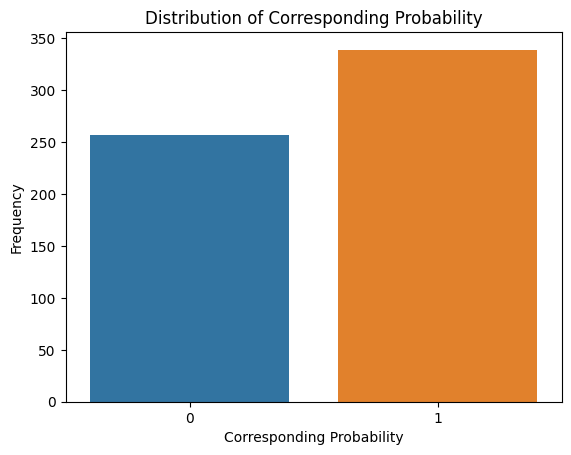

In [98]:
sns.countplot(x="corresponding_probability", data=df)
plt.xlabel("Corresponding Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Corresponding Probability")
plt.show()

<p><h3>Machine Learning</h3>
<h6>Apply machine learning algorithms to build predictive models or classify data based on patterns identified during analysis. This step involves selecting appropriate algorithms, training models, and evaluating their performance using metrics like accuracy, precision, recall, and F1-score.</h6></p>

In [99]:
X = df.drop(["corresponding_ranking", "corresponding_probability"], axis=1)
y = df["corresponding_probability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train -> {X_train.describe()}\nTest -> {X_test.describe()}")

Train ->             wrank        lrank          wpts          lpts       b365w  \
count  476.000000   476.000000    476.000000    476.000000  476.000000   
mean    60.590336    74.220588   1988.077731   1509.951681    2.237206   
std     59.345609    86.952181   2185.893006   1698.475557    1.617185   
min      1.000000     1.000000     95.000000      3.000000    1.010000   
25%     16.000000    26.000000    698.000000    615.750000    1.330000   
50%     46.000000    55.500000   1114.000000    948.500000    1.660000   
75%     89.000000    98.250000   2375.000000   1653.750000    2.500000   
max    437.000000  1415.000000  12415.000000  12355.000000   13.000000   

            b365l  b365w_probability  b365l_probability  
count  476.000000         476.000000         476.000000  
mean     3.056176           0.577791           0.475218  
std      2.782734           0.227133           0.227721  
min      1.040000           0.076923           0.038462  
25%      1.530000           0.4000

               Specs        Score
0              wrank    96.887574
1              lrank    48.052789
2               wpts    93.991858
3               lpts    57.588989
4              b365w   399.557835
5              b365l   187.575403
6  b365w_probability  1624.711021
7  b365l_probability  1593.464912


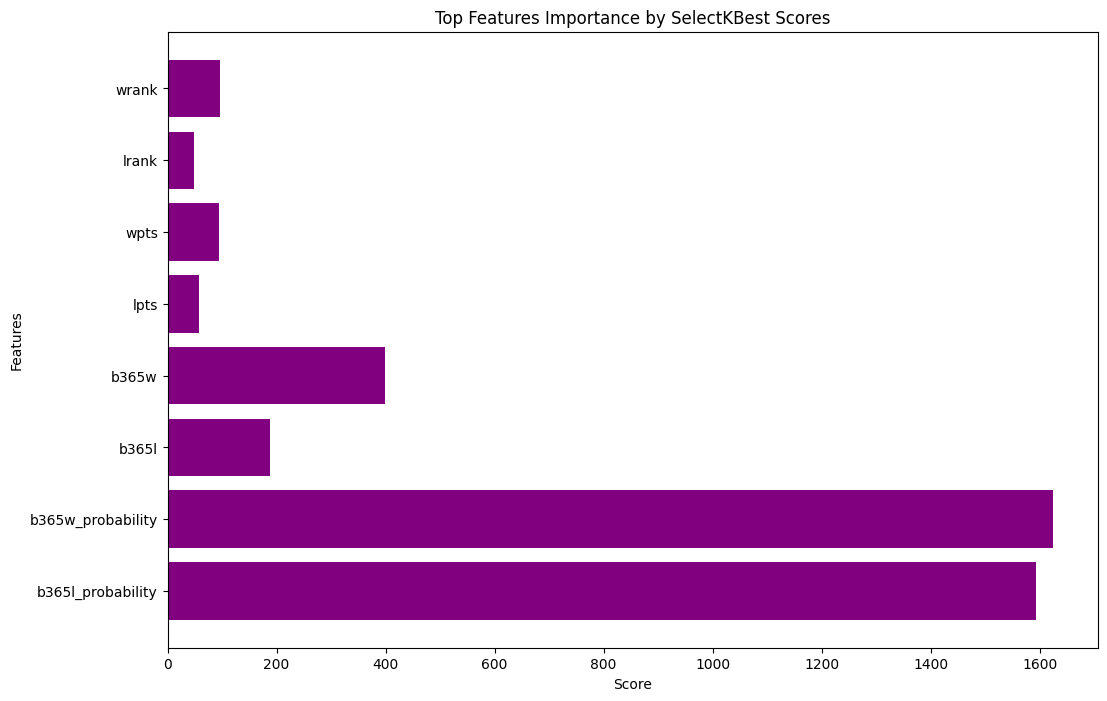

In [100]:
# SelectKBest
select_kbest = SelectKBest(k="all")
fit = select_kbest.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
featureScores = pd.concat([df_columns, df_scores], axis=1)
featureScores.columns = ["Specs", "Score"]
featureScores.nlargest(10, "Score").set_index("Specs")
print(featureScores)

# Plotting the Feature Scores
plt.figure(figsize=(12, 8))
plt.barh(featureScores["Specs"], featureScores["Score"], color="purple")
plt.xlabel("Score")
plt.ylabel("Features")
plt.title("Top Features Importance by SelectKBest Scores")
plt.gca().invert_yaxis()
plt.savefig("../reports/feature_importance.png")
plt.show()